In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\yong\anaconda3\envs\textmining_cpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [4]:
num_classes = 10
input_shape = (28, 28, 1)
image_size = 32  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [512, 128]  # Size of the dense layers of the final classifier

In [5]:
preprocessing = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="preprocessing",
)
# Compute the mean and the variance of the training data for normalization.
preprocessing.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [9]:

image = x_train[np.random.choice(range(x_train.shape[0]))]

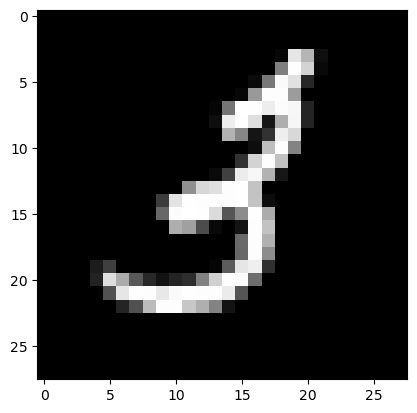

In [10]:

plt.imshow(image.astype("uint8"), cmap='gray')



(0.0, 1.0, 0.0, 1.0)

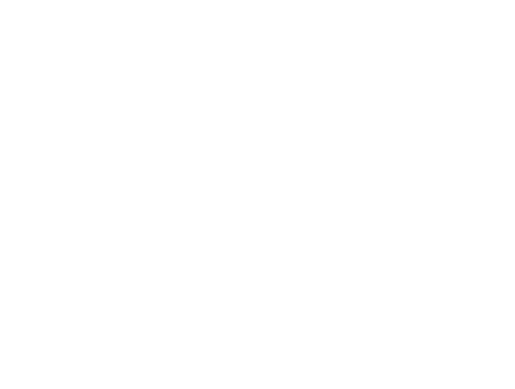

In [11]:
plt.axis("off")

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 16
The shape of patches:  (1, 64, 16)


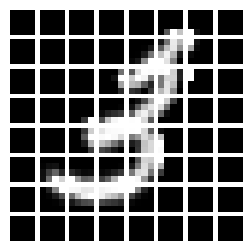

In [12]:

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print("The shape of patches: ", patches.shape)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(3, 3))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

In [13]:
class PatchEncoder(layers.Layer):
    """
    The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.
    """
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [14]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    preprocessed = preprocessing(inputs) # 입력 이미지에 대한 전처리 수행, 즉 표준화와 resize
    patches = Patches(patch_size)(preprocessed) # 이미지를 패치 단위로 분할
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # 각 패치에 대한 임베딩 벡터 생성

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
model = create_vit_classifier()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 preprocessing (Sequential)     (None, 32, 32, 1)    3           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 16)     0           ['preprocessing[0][0]']          
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 64, 64)       5184        ['patches_1[0][0]']              
                                                                                              

In [17]:
from tensorflow.keras.utils import to_categorical 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [18]:
model.compile(
    optimizer=tf.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_tr1"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [20]:
history = model.fit(x_train,y_train_one_hot, batch_size=128, epochs=10,
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
422/422 [==============================] - 114s 264ms/step - loss: 1.4464 - accuracy: 0.5276 - val_loss: 0.3439 - val_accuracy: 0.9102
Epoch 2/10
422/422 [==============================] - 105s 249ms/step - loss: 0.6459 - accuracy: 0.7953 - val_loss: 0.2140 - val_accuracy: 0.9395
Epoch 3/10
422/422 [==============================] - 103s 245ms/step - loss: 0.4673 - accuracy: 0.8606 - val_loss: 0.1568 - val_accuracy: 0.9568
Epoch 4/10
422/422 [==============================] - 99s 235ms/step - loss: 0.3790 - accuracy: 0.8876 - val_loss: 0.1375 - val_accuracy: 0.9630
Epoch 5/10
422/422 [==============================] - 102s 241ms/step - loss: 0.3198 - accuracy: 0.9062 - val_loss: 0.1106 - val_accuracy: 0.9673
Epoch 6/10
422/422 [==============================] - 102s 243ms/step - loss: 0.2783 - accuracy: 0.9219 - val_loss: 0.0974 - val_accuracy: 0.9730
Epoch 7/10
422/422 [==============================] - 102s 241ms/step - loss: 0.2494 - accuracy: 0.9281 - val_loss: 0.0919 - 

In [21]:
model.load_weights(checkpoint_filepath)

In [22]:
model.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 7s 22ms/step - loss: 0.0754 - accuracy: 0.9769


[0.07541953772306442, 0.9768999814987183]